In [1]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '/work/scripts/util')
from output import load_trsc_dataframe

In [2]:
import netCDF4 as nc
import numpy as np
from matplotlib import pyplot as plt
import os
import json
import pandas as pd
import seaborn as sns
import xarray as xr
from output import load_trsc_dataframe
import seaborn as sns

In [3]:
cell_y_coord=0
cell_x_coord=0

In [4]:
#model run level information

data_paths=['/data/workflows/BONA-black-spruce-fire-control/output/',
            '/data/workflows/BONA-black-spruce-fire-1930/output/',
            '/data/workflows/BONA-black-spruce-fire-1960/output/',
            '/data/workflows/BONA-black-spruce-fire-1990/output/',
            '/data/workflows/BONA-birch-fire-control/output/',
            '/data/workflows/BONA-birch-fire-1930/output/',
           '/data/workflows/BONA-birch-fire-1960/output/',
            '/data/workflows/BONA-birch-fire-1990/output/'
           ]
#data_paths=['/data/workflows/BONA-black-spruce-fire-control-nfix/output/',
#            '/data/workflows/BONA-black-spruce-fire-1930-nfix/output/',
#            '/data/workflows/BONA-black-spruce-fire-1960-nfix/output/',
#            '/data/workflows/BONA-black-spruce-fire-1990-nfix/output/',
#            '/data/workflows/BONA-birch-fire-control-nfix/output/',
#            '/data/workflows/BONA-birch-fire-1930-nfix/output/',
#            '/data/workflows/BONA-birch-fire-1960-nfix/output/',
#            '/data/workflows/BONA-birch-fire-1990-nfix/output/'
#           ]

#data_paths=['/data/workflows/BONA-black-spruce-fire-control-rhmoist/output/',
#            '/data/workflows/BONA-black-spruce-fire-1930-rhmoist/output/',
#            '/data/workflows/BONA-black-spruce-fire-1960-rhmoist/output/',
#            '/data/workflows/BONA-black-spruce-fire-1990-rhmoist/output/',
#            '/data/workflows/BONA-birch-fire-control-rhmoist/output/',
#            '/data/workflows/BONA-birch-fire-1930-rhmoist/output/',
#           '/data/workflows/BONA-birch-fire-1960-rhmoist/output/',
#            '/data/workflows/BONA-birch-fire-1990-rhmoist/output/'
#           ]

exp = ['control', 
       'burn_1930', 
       'burn_1960', 
       'burn_1990',
       'control', 
       'burn_1930', 
       'burn_1960', 
       'burn_1990']

cmt = ['black_spruce', 
       'black_spruce', 
       'black_spruce', 
       'black_spruce',
       'birch', 
       'birch', 
       'birch', 
       'birch']

pfts = {'black_spruce': ['Black Spruce', 'Decid. Shrub', 'Evr. Shrub', 'Moss', 'Lichen'],
        'birch': ['White Spruce', 'Decid. Shrub', 'Birch', 'Moss', 'Evr. Shrub']}

burn_year = [1900, 
             1930, 
             1960, 
             1990,
             1900, 
             1930, 
             1960, 
             1990]

#variable-level information, assuming same outputs from each model run
var_list = ['GPP', 
            'NPP', 
            'RH', 
            'RG', 
            'RM',
            'LTRFALC',
            'SHLWC',
            'VEGC',
            'DEEPC',
            'MINEC',
            'AVLN',
            'ALD',
            'SHLWDZ',
            'DEEPDZ',
            'WATERTAB',
            'EET',
            'PET',
            'SOMA',
            'SOMCR',
            'SOMPR',
            'SOMRAWC'
           ]

timeres = ['monthly', 
           'monthly', 
           'monthly', 
           'monthly',
           'monthly', 
           'monthly',
           'monthly',
           'monthly',
           'yearly',
           'yearly',
           'yearly',
           'yearly',
           'yearly',
           'yearly',
           'yearly',
           'yearly',
           'yearly',
           'yearly',
           'yearly',
           'yearly',
           'yearly'
            ]

year_agg = ['sum', 
               'sum', 
               'sum', 
               'sum', 
               'sum',
               'sum',
               'mean',
               'mean',
               'mean',
               'mean',
               'mean',
               'mean',
               'mean',
               'mean',
               'mean',
               'mean',
               'mean',
               'mean',
               'mean',
               'mean',
               'mean'
                ]

detail = ['cmt', 
          'cmt', 
          'cmt', 
          'cmt', 
          'cmt',
          'cmt',
          'cmt',
          'part',
          'cmt',
          'cmt',
          'cmt',
          'cmt',
          'cmt',
          'cmt',
          'cmt',
          'cmt',
          'cmt',
          'cmt',
          'cmt',
          'cmt',
          'cmt'
         ]

In [5]:
def get_monthly_data(data_path, var, cell_y_coord=0, cell_x_coord=0, year_agg='mean'):
    
    df_monthly = load_trsc_dataframe(var=var, timeres='monthly', px_y=cell_y_coord, px_x=cell_x_coord, fileprefix=data_path)[0].reset_index()
    df_monthly.columns = ['time', var]
    df_monthly['time'] = pd.to_datetime(df_monthly['time'])
    df_monthly['year'] = df_monthly['time'].dt.year

    if year_agg == 'mean':
        df_yearly = df_monthly[['year', var]].groupby(by='year').mean()
        
    if year_agg == 'sum':
        df_yearly = df_monthly[['year', var]].groupby(by='year').sum()
    
    return df_monthly, df_yearly

In [6]:
def get_yearly_data(data_path, var, cell_y_coord=0, cell_x_coord=0):
    
    df_yearly = load_trsc_dataframe(var=var, timeres='yearly', px_y=cell_y_coord, px_x=cell_x_coord, fileprefix=data_path)[0].reset_index()
    df_yearly.columns = ['time', var]
    df_yearly['time'] = pd.to_datetime(df_yearly['time'])
    df_yearly['year'] = df_yearly['time'].dt.year
    
    return df_yearly

In [7]:
def get_monthly_data_part(data_path, var, pfts, cell_y_coord=0, cell_x_coord=0, year_agg='mean'):
    
    df_monthly = xr.open_dataset(data_path+var+'_monthly_tr.nc')
    df_monthly = df_monthly.convert_calendar('standard', use_cftime=False, align_on='date')
    df_monthly = df_monthly.to_dataframe().reset_index()
    df_monthly = df_monthly.loc[(df_monthly['y']==cell_y_coord) & (df_monthly['x']==cell_x_coord) & (df_monthly['pft']<5)]
    df_monthly = df_monthly[['time','pft', 'pftpart', var]]
    df_monthly['year'] = df_monthly['time'].dt.year
    
    
    
    if year_agg== 'mean':
        df_yearly = df_monthly.groupby(by=['year', 'pft', 'pftpart']).mean().reset_index()
    
    if year_agg== 'sum':
        df_yearly = df_monthly.groupby(by=['year', 'pft', 'pftpart']).sum().reset_index()

    return df_monthly, df_yearly

In [8]:
def get_monthly_data_pft(data_path, var, pfts, cell_y_coord=0, cell_x_coord=0, year_agg='mean'):
    
    df_monthly = load_trsc_dataframe(var=var, timeres='monthly', px_y=cell_y_coord, px_x=cell_x_coord, fileprefix=data_path)[0].reset_index()
    
    df_monthly = df_monthly[['index', 0, 1, 2, 3, 4]]
    df_monthly.columns = ['time']+pfts
    print(df_monthly.head())
    df_monthly['time'] = pd.to_datetime(df_monthly['time'])
    df_monthly['year'] = df_monthly['time'].dt.year
    
    if year_agg== 'mean':
        df_yearly = df_monthly[['year']+pfts].groupby(by='year').mean().reset_index()
    
    if year_agg== 'sum':
        df_yearly = df_monthly[['year']+pfts].groupby(by='year').sum().reset_index()

    return df_monthly, df_yearly

In [9]:
depthlist = [0.08, 0.1, 0.2, 0.3]

def get_lwclayer_tlayer(depthlist, run_dir, var):
    
    ### read the netcdf output files and compute year from the time dimension
    data = xr.open_dataset(f'{run_dir}/output/{var}_yearly_tr.nc')
    data = data.to_dataframe()
    data.reset_index(inplace=True)
    data.dtypes
    data['time'] = data['time'].astype('|S80')
    data['time'] = data['time'].astype('|datetime64[ns]')
    data['month'] = data['time'].dt.month
    data['year'] = data['time'].dt.year
    data = data.sort_values(['time','x','y','layer'])


    ### read the netcdf output files on soil structure and compute year from the time dimension
    dz = xr.open_dataset(f'{run_dir}/output/LAYERDZ_yearly_tr.nc')
    dz = dz.to_dataframe()
    dz.reset_index(inplace=True)
    dz.dtypes
    dz['time'] = dz['time'].astype('|S80')
    dz['time'] = dz['time'].astype('|datetime64[ns]')
    dz['month'] = dz['time'].dt.month
    dz['year'] = dz['time'].dt.year
    dz = dz.sort_values(['time','x','y','layer'])

    ### read the netcdf output files on soil structure and compute year from the time dimension
    lt = xr.open_dataset(f'{run_dir}/output/LAYERTYPE_yearly_tr.nc')
    lt = lt.to_dataframe()
    lt.reset_index(inplace=True)
    lt.dtypes
    lt['time'] = lt['time'].astype('|S80')
    lt['time'] = lt['time'].astype('|datetime64[ns]')
    #lt['month'] = lt['time'].dt.month
    lt['year'] = lt['time'].dt.year
    lt = lt.sort_values(['time','x','y','layer'])
    dz=pd.merge(dz, lt[['LAYERTYPE', 'time', 'x', 'y', 'layer']], on=['time','x','y','layer'])


    ### compute the depth of the bottom of every layers
    dz['z'] = dz.groupby(['time','x','y'])['LAYERDZ'].cumsum(axis=0)
    
    ### loop through the list of depths of reference to compute the soil variable at that depth via linear interpolation
    stdz = []
    for i in range(len(depthlist)):
        dpth = depthlist[i]
        print("depth:", dpth,"m")
        # extract the top and bottom layers the closest to the depth of reference
        dz['diff'] = dz['z']-float(dpth)
        top = dz.loc[dz[(dz['diff'] <= 0)].groupby(['time','x','y'])['diff'].idxmax()]
        bot = dz.loc[dz[(dz['diff'] >= 0)].groupby(['time','x','y'])['diff'].idxmin()]
        # select the variable value for each of these top and bottom layers
        datatop = pd.merge(data, top[['year','month', 'x','y','layer','LAYERDZ','LAYERTYPE','z']], how="left", on=['layer','year','month', 'x','y'])
        datatop = datatop[datatop['z'].notna()]
        datatop = datatop.rename(columns={"layer": "layertop", var: var+"top", "LAYERDZ": "dztop", "z": "ztop", "LAYERTYPE": "typetop"})
        databot = pd.merge(data, bot[['year', 'month', 'x','y','layer','LAYERDZ','LAYERTYPE','z']], how="left", on=['layer','year','month' , 'x','y'])
        databot = databot[databot['z'].notna()]
        databot = databot.rename(columns={"layer": "layerbot", var: var+"bot", "LAYERDZ": "dzbot", "z": "zbot", "LAYERTYPE": "typebot"})
        # merge the data to do the linear interpolation
        datastdz = pd.merge(datatop, databot, how="outer", on=['time','year', 'month', 'x','y'])
        datastdz['a'] = (datastdz[var+"top"] - datastdz[var+"bot"]) / (datastdz['ztop'] - datastdz['zbot'])
        datastdz['b'] = datastdz[var+"top"] - (datastdz['a'] * datastdz['ztop'])
        datastdz[var] = (datastdz['a'] * float(dpth)) + datastdz['b']
        datastdz[var+'_top'] = datastdz[var+"top"]
        datastdz[var+'_bot'] = datastdz[var+"bot"]
        datastdz['z'] = float(dpth)
        datastdz['layer'] = i
        datastdz['type'] = datastdz['typebot']
        datastdz = datastdz[['time','year', 'x','y','layer','z','type',var, var+'_top', var+'_bot']]
        stdz.append(datastdz)

    stdz = pd.concat(stdz)
    
    return stdz

In [10]:
lwc_layers = []
t_layers = []

for i, d in enumerate(data_paths):
    if 'GPP_monthly_tr.nc' in os.listdir(d):
        d='/'.join(d.split('/')[:-2])
        print(d)

        TLAYER = load_trsc_dataframe(var ='TLAYER', timeres='yearly', px_y=cell_y_coord, px_x=cell_x_coord, fileprefix=f'{d}/output/')[0]
        LAYERDEPTH = load_trsc_dataframe(var ='LAYERDEPTH', timeres='yearly', px_y=cell_y_coord, px_x=cell_x_coord, fileprefix=f'{d}/output/')[0]
        LAYERDZ = load_trsc_dataframe(var ='LAYERDZ', timeres='yearly', px_y=cell_y_coord, px_x=cell_x_coord, fileprefix=f'{d}/output/')[0]
        
        LWCLAYER = get_lwclayer_tlayer(depthlist, d, 'LWCLAYER')
        LWCLAYER['exp'] = exp[i]
        LWCLAYER['cmt'] = cmt[i]
        lwc_layers.append(LWCLAYER)
        
        TLAYER = get_lwclayer_tlayer(depthlist, d, 'TLAYER')
        TLAYER['exp'] = exp[i]
        TLAYER['cmt'] = cmt[i]
        t_layers.append(TLAYER)
        
lwc_layers=pd.concat(lwc_layers)
t_layers=pd.concat(t_layers)

/data/workflows/BONA-black-spruce-fire-control
Trying to open:  /data/workflows/BONA-black-spruce-fire-control/output/TLAYER_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-control/output/LAYERDEPTH_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-control/output/LAYERDZ_yearly_tr.nc
depth: 0.08 m
depth: 0.1 m
depth: 0.2 m
depth: 0.3 m
depth: 0.08 m
depth: 0.1 m
depth: 0.2 m
depth: 0.3 m
/data/workflows/BONA-black-spruce-fire-1930
Trying to open:  /data/workflows/BONA-black-spruce-fire-1930/output/TLAYER_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1930/output/LAYERDEPTH_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1930/output/LAYERDZ_yearly_tr.nc
depth: 0.08 m
depth: 0.1 m
depth: 0.2 m
depth: 0.3 m
depth: 0.08 m
depth: 0.1 m
depth: 0.2 m
depth: 0.3 m
/data/workflows/BONA-black-spruce-fire-1960
Trying to open:  /data/workflows/BONA-black-spruce-fire-1960/output/TLAYER_yearly_tr.nc
Trying to open:  /

In [11]:
def create_df_for_var(data_paths, exps, cmts, burn_year, var, timeres, detail, year_agg=None, pfts=None):
    
    dfs_monthly=[]
    dfs_yearly=[]
    
    for i, data_path in enumerate(data_paths):
        if timeres=='monthly':
            
            if detail=='pft':
                df_monthly, df_yearly = get_monthly_data_pft(data_path, var, pfts[cmts[i]], 
                                                             cell_y_coord=0, cell_x_coord=0, year_agg=year_agg)
                
                df_monthly = df_monthly.melt(id_vars=['time', 'year'])
                df_monthly.columns = ['time', 'year', 'pft', var]
                
                df_yearly = df_yearly.melt(id_vars=['year'])
                df_yearly.columns = ['year', 'pft', var]
                
            if detail=='part':
                df_monthly, df_yearly = get_monthly_data_part(data_path, var, pfts[cmts[i]], 
                                                             cell_y_coord=0, cell_x_coord=0, year_agg=year_agg)
                
                #print(df_monthly.head())
                #df_monthly = df_monthly.melt(id_vars=['time', 'year'])
                #print(df_monthly.head())
                #df_monthly.columns = ['time', 'year', 'pft', 'pftpart', var]
                
                #df_yearly = df_yearly.melt(id_vars=['year'])
                #df_yearly.columns = ['year', 'pft', 'pftpart', var]
                
            else:
                df_monthly, df_yearly = get_monthly_data(data_path, var, year_agg=year_agg)
        
            df_monthly['exp'] = exps[i]
            df_monthly['cmt'] = cmts[i]
            df_monthly['burn_year'] = burn_year[i]
        
        if timeres=='yearly':
            df_yearly=get_yearly_data(data_path, var)
            df_monthly=pd.DataFrame(columns = ['time', 'year', 'pft', var, 'exp', 'cmt', 'burn_year'])
            
        df_yearly['exp'] = exps[i]
        df_yearly['cmt'] = cmts[i]
        df_yearly['burn_year'] = burn_year[i]

        dfs_monthly.append(df_monthly)
        dfs_yearly.append(df_yearly)
            
    dfs_monthly = pd.concat(dfs_monthly)
    dfs_yearly = pd.concat(dfs_yearly)
    
    return dfs_monthly, dfs_yearly

In [12]:
#get monthly data, not defined by pft

results_monthly = pd.DataFrame()
results_yearly = pd.DataFrame()

results_monthly_pft = pd.DataFrame()
results_yearly_pft = pd.DataFrame()

results_monthly_part = pd.DataFrame()
results_yearly_part = pd.DataFrame()

for i, var in enumerate(var_list):
    print(detail[i])
    var_monthly, var_yearly = create_df_for_var(data_paths, exp, cmt, burn_year, var, timeres[i], detail[i], year_agg[i], pfts)
        
    if (detail[i] == 'pft'):
        
        if len(results_monthly_pft)==0:

            results_monthly_pft = var_monthly
            results_yearly_pft = var_yearly
            
        else:
            if len(var_monthly)>0:
                results_monthly_pft = pd.merge(results_monthly_pft, var_monthly, on=['time', 'year', 'exp', 'cmt', 'burn_year', 'pft'])
            results_yearly_pft = pd.merge(results_yearly_pft, var_yearly, on=['year', 'exp', 'cmt', 'burn_year', 'pft'])
            
    if (detail[i] == 'part'):
        print(var_yearly) 
        if len(results_monthly_part)==0:

            results_monthly_part = var_monthly
            results_yearly_part = var_yearly
               
        else:
            if len(var_monthly)>0:
                results_monthly_part = pd.merge(results_monthly_part, var_monthly, on=['time', 'year', 'exp', 'cmt', 'burn_year', 'pft', 'pftpart'])
            results_yearly_part = pd.merge(results_yearly_part, var_yearly, on=['year', 'exp', 'cmt', 'burn_year', 'pft', 'pftpart'])
         
    else:
        
        if len(results_monthly)==0:

            results_monthly = var_monthly
            results_yearly = var_yearly
            
        else:
            if len(var_monthly)>0:
                results_monthly = pd.merge(results_monthly, var_monthly, on=['time', 'year', 'exp', 'cmt', 'burn_year'])
            results_yearly = pd.merge(results_yearly, var_yearly, on=['year', 'exp', 'cmt', 'burn_year'])
    
results_yearly = results_yearly.reset_index()

cmt
Trying to open:  /data/workflows/BONA-black-spruce-fire-control/output/GPP_monthly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1930/output/GPP_monthly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1960/output/GPP_monthly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1990/output/GPP_monthly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-control/output/GPP_monthly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-1930/output/GPP_monthly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-1960/output/GPP_monthly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-1990/output/GPP_monthly_tr.nc
cmt
Trying to open:  /data/workflows/BONA-black-spruce-fire-control/output/NPP_monthly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1930/output/NPP_monthly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1960/output/NPP_monthly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1990/outp

/tmp/ipykernel_78344/540029826.py:50: FutureWarning: Passing 'suffixes' which cause duplicate columns {'time_x'} in the result is deprecated and will raise a MergeError in a future version.
  results_yearly = pd.merge(results_yearly, var_yearly, on=['year', 'exp', 'cmt', 'burn_year'])


cmt
Trying to open:  /data/workflows/BONA-black-spruce-fire-control/output/SHLWDZ_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1930/output/SHLWDZ_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1960/output/SHLWDZ_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1990/output/SHLWDZ_yearly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-control/output/SHLWDZ_yearly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-1930/output/SHLWDZ_yearly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-1960/output/SHLWDZ_yearly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-1990/output/SHLWDZ_yearly_tr.nc
cmt
Trying to open:  /data/workflows/BONA-black-spruce-fire-control/output/DEEPDZ_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1930/output/DEEPDZ_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1960/output/DEEPDZ_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black

/tmp/ipykernel_78344/540029826.py:50: FutureWarning: Passing 'suffixes' which cause duplicate columns {'time_x'} in the result is deprecated and will raise a MergeError in a future version.
  results_yearly = pd.merge(results_yearly, var_yearly, on=['year', 'exp', 'cmt', 'burn_year'])


Trying to open:  /data/workflows/BONA-birch-fire-1930/output/EET_yearly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-1960/output/EET_yearly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-1990/output/EET_yearly_tr.nc
cmt
Trying to open:  /data/workflows/BONA-black-spruce-fire-control/output/PET_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1930/output/PET_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1960/output/PET_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1990/output/PET_yearly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-control/output/PET_yearly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-1930/output/PET_yearly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-1960/output/PET_yearly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-1990/output/PET_yearly_tr.nc
cmt
Trying to open:  /data/workflows/BONA-black-spruce-fire-control/output/SOMA_yearly_tr.nc
Trying to o

/tmp/ipykernel_78344/540029826.py:50: FutureWarning: Passing 'suffixes' which cause duplicate columns {'time_x'} in the result is deprecated and will raise a MergeError in a future version.
  results_yearly = pd.merge(results_yearly, var_yearly, on=['year', 'exp', 'cmt', 'burn_year'])


Trying to open:  /data/workflows/BONA-black-spruce-fire-1990/output/SOMA_yearly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-control/output/SOMA_yearly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-1930/output/SOMA_yearly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-1960/output/SOMA_yearly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-1990/output/SOMA_yearly_tr.nc
cmt
Trying to open:  /data/workflows/BONA-black-spruce-fire-control/output/SOMCR_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1930/output/SOMCR_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1960/output/SOMCR_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1990/output/SOMCR_yearly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-control/output/SOMCR_yearly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-1930/output/SOMCR_yearly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-1960/output/SOMCR_yearly_tr.

/tmp/ipykernel_78344/540029826.py:50: FutureWarning: Passing 'suffixes' which cause duplicate columns {'time_x'} in the result is deprecated and will raise a MergeError in a future version.
  results_yearly = pd.merge(results_yearly, var_yearly, on=['year', 'exp', 'cmt', 'burn_year'])


cmt
Trying to open:  /data/workflows/BONA-black-spruce-fire-control/output/SOMPR_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1930/output/SOMPR_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1960/output/SOMPR_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1990/output/SOMPR_yearly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-control/output/SOMPR_yearly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-1930/output/SOMPR_yearly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-1960/output/SOMPR_yearly_tr.nc
Trying to open:  /data/workflows/BONA-birch-fire-1990/output/SOMPR_yearly_tr.nc
cmt
Trying to open:  /data/workflows/BONA-black-spruce-fire-control/output/SOMRAWC_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1930/output/SOMRAWC_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spruce-fire-1960/output/SOMRAWC_yearly_tr.nc
Trying to open:  /data/workflows/BONA-black-spru

/tmp/ipykernel_78344/540029826.py:50: FutureWarning: Passing 'suffixes' which cause duplicate columns {'time_x'} in the result is deprecated and will raise a MergeError in a future version.
  results_yearly = pd.merge(results_yearly, var_yearly, on=['year', 'exp', 'cmt', 'burn_year'])


In [13]:
results_yearly_part

,year,pft,pftpart,VEGC,exp,cmt,burn_year
0,1901,0,0,299.263727,control,black_spruce,1900
1,1901,0,1,2634.393901,control,black_spruce,1900
2,1901,0,2,582.005142,control,black_spruce,1900
3,1901,1,0,122.045612,control,black_spruce,1900
4,1901,1,1,226.871493,control,black_spruce,1900
...,...,...,...,...,...,...,...
1825,2022,3,1,0.000000,burn_1990,birch,1990
1826,2022,3,2,0.000000,burn_1990,birch,1990
1827,2022,4,0,2.600955,burn_1990,birch,1990
1828,2022,4,1,128.995651,burn_1990,birch,1990


In [14]:
results_yearly_pft = results_yearly_part.groupby(by=['burn_year', 'cmt', 'exp', 'year', 'pft']).sum().reset_index()
results_yearly_pft['pft'] = results_yearly_pft['pft'].apply(str)
results_yearly_pft

,burn_year,cmt,exp,year,pft,pftpart,VEGC
0,1900,birch,control,1901,0,3,3.338592
1,1900,birch,control,1901,1,3,224.404629
2,1900,birch,control,1901,2,3,2584.512826
3,1900,birch,control,1901,3,3,196.283455
4,1900,birch,control,1901,4,3,132.246217
...,...,...,...,...,...,...,...
4875,1990,black_spruce,burn_1990,2022,0,3,631.398696
4876,1990,black_spruce,burn_1990,2022,1,3,266.015538
4877,1990,black_spruce,burn_1990,2022,2,3,180.390082
4878,1990,black_spruce,burn_1990,2022,3,3,2302.547058


In [15]:
results_yearly['RECO'] = results_yearly['RG'] + results_yearly['RM'] + results_yearly['RH']
results_yearly['NEE'] = results_yearly['RECO'] - results_yearly['GPP']
results_yearly['years_since_fire'] = results_yearly['year'] - results_yearly['burn_year']
#results_yearly = results_yearly.loc[(results_yearly['exp']=='burn_1930') | (results_yearly['exp']=='control')]

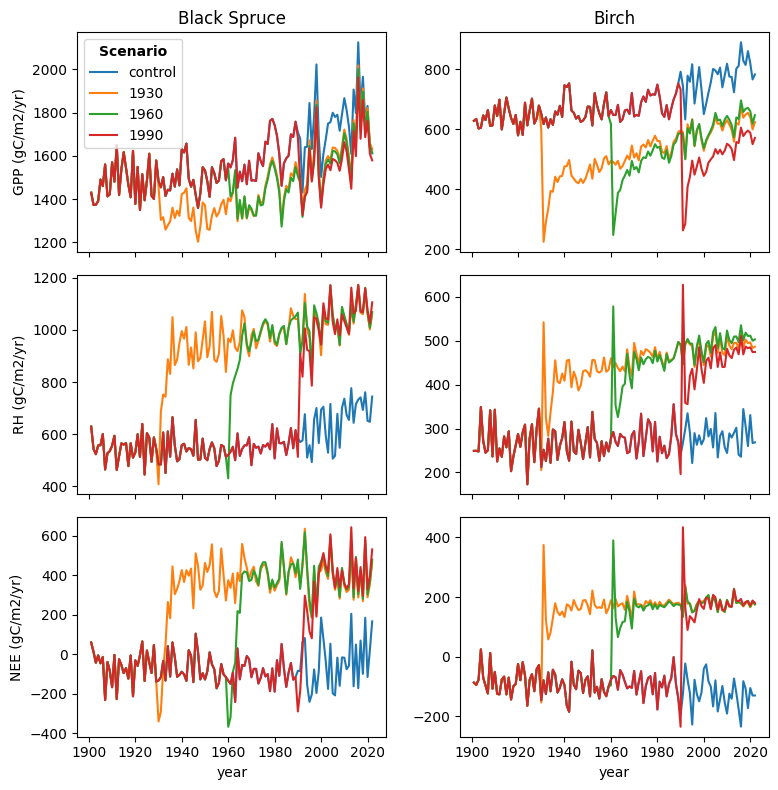

In [16]:
fig, axes = plt.subplots(3,2, figsize=(8,8), sharex=True)


sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], x='year', y='GPP', hue='exp', ax=axes[0][0])
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], x='year', y='RH', hue='exp', ax=axes[1][0], legend=False)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], x='year', y='NEE', hue='exp', ax=axes[2][0], legend=False)

axes[0][0].set_title('Black Spruce')
axes[0][0].set_ylabel('GPP (gC/m2/yr)')

new_labels = ['control', '1930', '1960', '1990']
legend=axes[0,0].legend(title='Scenario', frameon=True, title_fontproperties={'weight':'bold'}, fontsize=10)
for text, new_label in zip(legend.get_texts(), new_labels):
    text.set_text(new_label)
    
axes[1][0].set_ylabel('RH (gC/m2/yr)')
axes[2][0].set_ylabel('NEE (gC/m2/yr)')

sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], x='year', y='GPP', hue='exp', ax=axes[0][1], legend=False)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], x='year', y='RH', hue='exp', ax=axes[1][1], legend=False)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], x='year', y='NEE', hue='exp', ax=axes[2][1], legend=False)

axes[0][1].set_ylabel('')
axes[1][1].set_ylabel('')
axes[2][1].set_ylabel('')

axes[0][1].set_title('Birch')


fig.tight_layout()

plt.savefig('C_Fluxes_fire_exps.jpg', dpi=300)

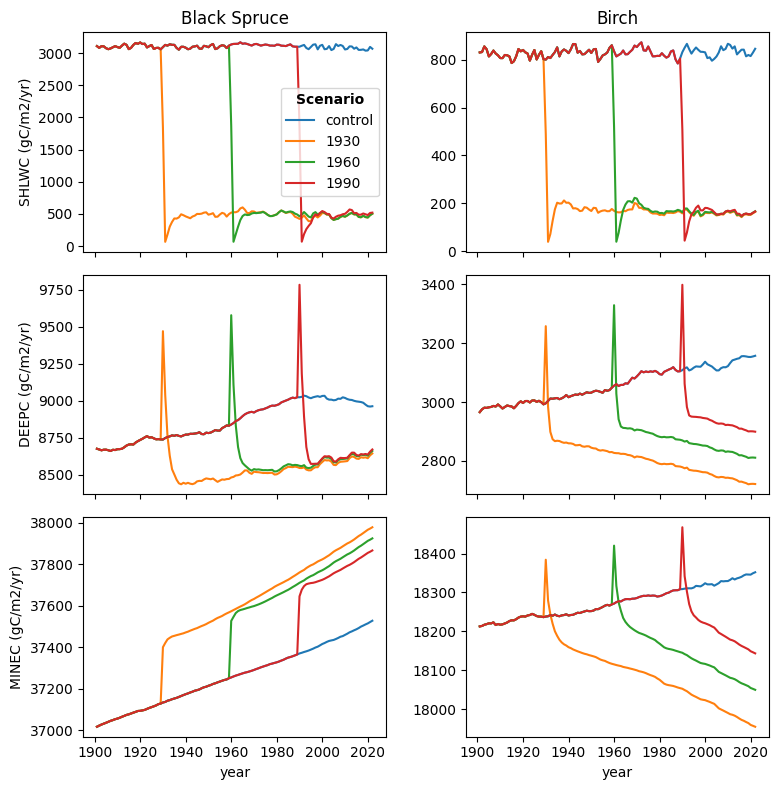

In [17]:
fig, axes = plt.subplots(3,2, figsize=(8,8), sharex=True)


sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], x='year', y='SHLWC', hue='exp', ax=axes[0][0])
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], x='year', y='DEEPC', hue='exp', ax=axes[1][0], legend=False)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], x='year', y='MINEC', hue='exp', ax=axes[2][0], legend=False)

axes[0][0].set_title('Black Spruce')
axes[0][0].set_ylabel('SHLWC (gC/m2/yr)')

new_labels = ['control', '1930', '1960', '1990']
legend=axes[0,0].legend(title='Scenario', frameon=True, title_fontproperties={'weight':'bold'}, fontsize=10)
for text, new_label in zip(legend.get_texts(), new_labels):
    text.set_text(new_label)
    
axes[1][0].set_ylabel('DEEPC (gC/m2/yr)')
axes[2][0].set_ylabel('MINEC (gC/m2/yr)')

sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], x='year', y='SHLWC', hue='exp', ax=axes[0][1], legend=False)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], x='year', y='DEEPC', hue='exp', ax=axes[1][1], legend=False)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], x='year', y='MINEC', hue='exp', ax=axes[2][1], legend=False)

axes[0][1].set_ylabel('')
axes[1][1].set_ylabel('')
axes[2][1].set_ylabel('')

axes[0][1].set_title('Birch')


fig.tight_layout()
plt.savefig('Soil_C_fire_exps.jpg', dpi=300)

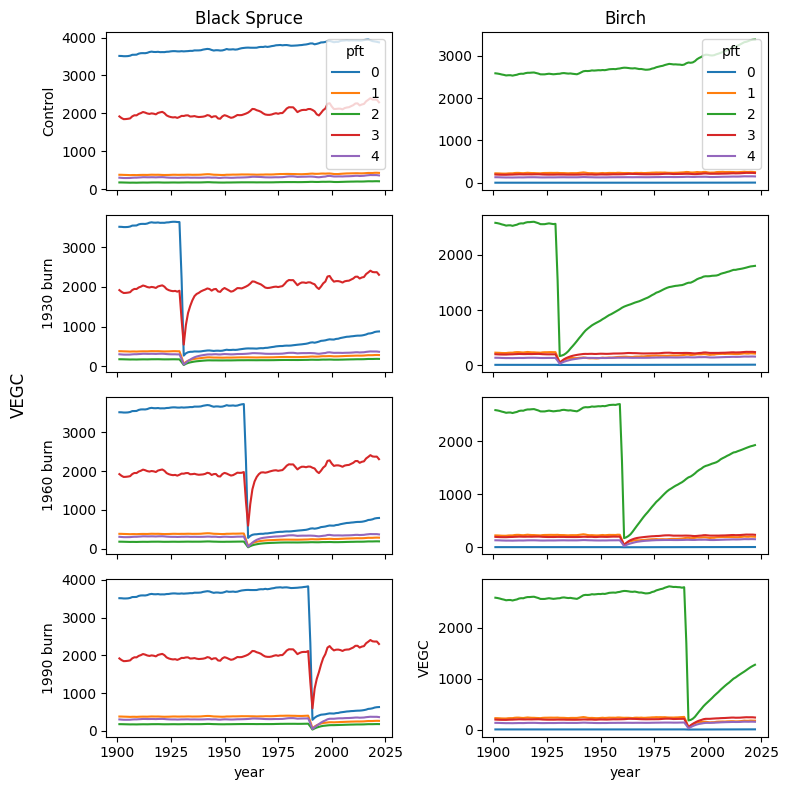

In [18]:
fig, axes = plt.subplots(4,2, figsize=(8,8), sharex=True)


sns.lineplot(data=results_yearly_pft.loc[(results_yearly_pft['cmt']=='black_spruce') & (results_yearly_pft['exp']=='control')], 
             x='year', y='VEGC', hue='pft', ax=axes[0][0])
sns.lineplot(data=results_yearly_pft.loc[(results_yearly_pft['cmt']=='black_spruce') & (results_yearly_pft['exp']=='burn_1930')], 
             x='year', y='VEGC', hue='pft', ax=axes[1][0], legend=False)
sns.lineplot(data=results_yearly_pft.loc[(results_yearly_pft['cmt']=='black_spruce') & (results_yearly_pft['exp']=='burn_1960')], 
             x='year', y='VEGC', hue='pft', ax=axes[2][0], legend=False)
sns.lineplot(data=results_yearly_pft.loc[(results_yearly_pft['cmt']=='black_spruce') & (results_yearly_pft['exp']=='burn_1990')], 
             x='year', y='VEGC', hue='pft', ax=axes[3][0], legend=False)

axes[0][0].set_title('Black Spruce')
axes[0][0].set_ylabel('Control')

    
axes[1][0].set_ylabel('1930 burn')
axes[2][0].set_ylabel('1960 burn')
axes[3][0].set_ylabel('1990 burn')

sns.lineplot(data=results_yearly_pft.loc[(results_yearly_pft['cmt']=='birch') & (results_yearly_pft['exp']=='control')], 
             x='year', y='VEGC', hue='pft', ax=axes[0][1])
sns.lineplot(data=results_yearly_pft.loc[(results_yearly_pft['cmt']=='birch') & (results_yearly_pft['exp']=='burn_1930')], 
             x='year', y='VEGC', hue='pft', ax=axes[1][1], legend=False)
sns.lineplot(data=results_yearly_pft.loc[(results_yearly_pft['cmt']=='birch') & (results_yearly_pft['exp']=='burn_1960')], 
             x='year', y='VEGC', hue='pft', ax=axes[2][1], legend=False)
sns.lineplot(data=results_yearly_pft.loc[(results_yearly_pft['cmt']=='birch') & (results_yearly_pft['exp']=='burn_1990')], 
             x='year', y='VEGC', hue='pft', ax=axes[3][1], legend=False)

axes[0][1].set_ylabel('')
axes[1][1].set_ylabel('')
axes[2][1].set_ylabel('')

axes[0][1].set_title('Birch')

fig.supylabel('VEGC')
fig.tight_layout()

plt.savefig('VEGC_fire_exps.jpg', dpi=300)

In [19]:
results_yearly_part

,year,pft,pftpart,VEGC,exp,cmt,burn_year
0,1901,0,0,299.263727,control,black_spruce,1900
1,1901,0,1,2634.393901,control,black_spruce,1900
2,1901,0,2,582.005142,control,black_spruce,1900
3,1901,1,0,122.045612,control,black_spruce,1900
4,1901,1,1,226.871493,control,black_spruce,1900
...,...,...,...,...,...,...,...
1825,2022,3,1,0.000000,burn_1990,birch,1990
1826,2022,3,2,0.000000,burn_1990,birch,1990
1827,2022,4,0,2.600955,burn_1990,birch,1990
1828,2022,4,1,128.995651,burn_1990,birch,1990


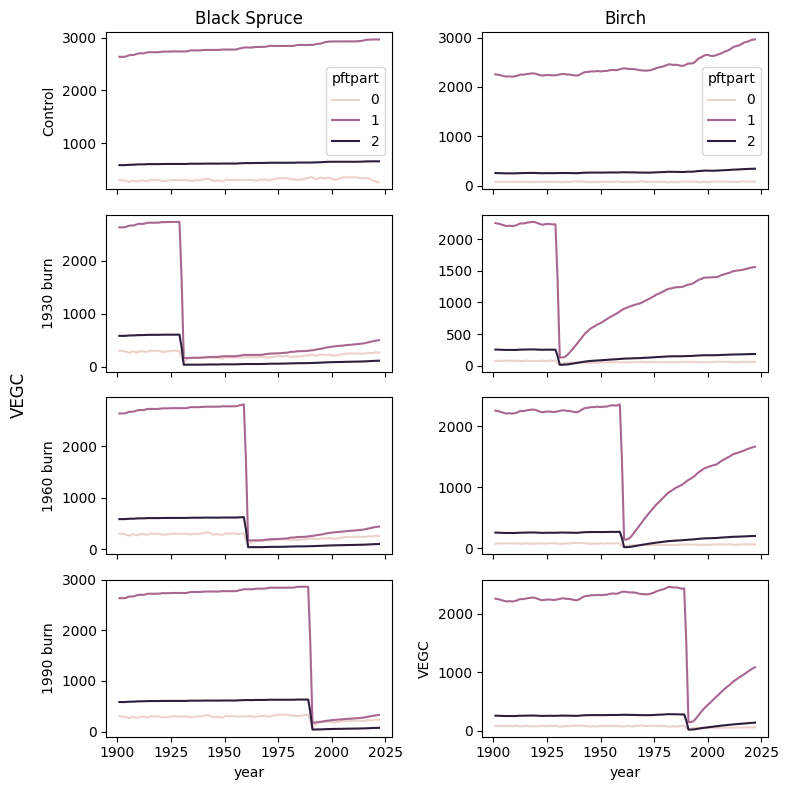

In [20]:
fig, axes = plt.subplots(4,2, figsize=(8,8), sharex=True)


sns.lineplot(data=results_yearly_part.loc[(results_yearly_part['cmt']=='black_spruce') & 
                                          (results_yearly_part['exp']=='control') &
                                          (results_yearly_part['pft']==0)], 
             x='year', y='VEGC', hue='pftpart', ax=axes[0][0])
sns.lineplot(data=results_yearly_part.loc[(results_yearly_part['cmt']=='black_spruce') & (results_yearly_part['exp']=='burn_1930')&
                                          (results_yearly_part['pft']==0)], 
             x='year', y='VEGC', hue='pftpart', ax=axes[1][0], legend=False)
sns.lineplot(data=results_yearly_part.loc[(results_yearly_part['cmt']=='black_spruce') & (results_yearly_part['exp']=='burn_1960')&
                                          (results_yearly_part['pft']==0)], 
             x='year', y='VEGC', hue='pftpart', ax=axes[2][0], legend=False)
sns.lineplot(data=results_yearly_part.loc[(results_yearly_part['cmt']=='black_spruce') & (results_yearly_part['exp']=='burn_1990')&
                                          (results_yearly_part['pft']==0)], 
             x='year', y='VEGC', hue='pftpart', ax=axes[3][0], legend=False)

axes[0][0].set_title('Black Spruce')
axes[0][0].set_ylabel('Control')

    
axes[1][0].set_ylabel('1930 burn')

#axes[1][0].set_ylim(0,500)

axes[2][0].set_ylabel('1960 burn')
axes[3][0].set_ylabel('1990 burn')

sns.lineplot(data=results_yearly_part.loc[(results_yearly_part['cmt']=='birch') & (results_yearly_part['exp']=='control')&
                                          (results_yearly_part['pft']==2)], 
             x='year', y='VEGC', hue='pftpart', ax=axes[0][1])
sns.lineplot(data=results_yearly_part.loc[(results_yearly_part['cmt']=='birch') & (results_yearly_part['exp']=='burn_1930')&
                                          (results_yearly_part['pft']==2)], 
             x='year', y='VEGC', hue='pftpart', ax=axes[1][1], legend=False)
sns.lineplot(data=results_yearly_part.loc[(results_yearly_part['cmt']=='birch') & (results_yearly_part['exp']=='burn_1960')&
                                          (results_yearly_part['pft']==2)], 
             x='year', y='VEGC', hue='pftpart', ax=axes[2][1], legend=False)
sns.lineplot(data=results_yearly_part.loc[(results_yearly_part['cmt']=='birch') & (results_yearly_part['exp']=='burn_1990')&
                                          (results_yearly_part['pft']==2)], 
             x='year', y='VEGC', hue='pftpart', ax=axes[3][1], legend=False)

axes[0][1].set_ylabel('')
axes[1][1].set_ylabel('')
axes[2][1].set_ylabel('')

axes[0][1].set_title('Birch')

fig.supylabel('VEGC')
fig.tight_layout()

plt.savefig('VEGC_tree_fire_exps.jpg', dpi=300)

In [21]:
t_layers

,time,year,x,y,layer,z,type,TLAYER,TLAYER_top,TLAYER_bot,exp,cmt
0,1901-01-01,1901,0,0,0,0.08,1.0,2.526955,3.125731,1.905628,control,black_spruce
1,1902-01-01,1902,0,0,0,0.08,1.0,3.796377,6.179176,3.026494,control,black_spruce
2,1903-01-01,1903,0,0,0,0.08,1.0,2.859782,4.960881,2.168512,control,black_spruce
3,1904-01-01,1904,0,0,0,0.08,1.0,-0.201931,0.334260,-0.748707,control,black_spruce
4,1905-01-01,1905,0,0,0,0.08,1.0,3.143772,5.516319,2.354844,control,black_spruce
...,...,...,...,...,...,...,...,...,...,...,...,...
117,2018-01-01,2018,0,0,3,0.30,3.0,0.380094,0.459858,0.370576,burn_1990,birch
118,2019-01-01,2019,0,0,3,0.30,3.0,0.474924,0.667128,0.452414,burn_1990,birch
119,2020-01-01,2020,0,0,3,0.30,3.0,0.261768,0.288810,0.258605,burn_1990,birch
120,2021-01-01,2021,0,0,3,0.30,3.0,-2.141788,-2.086857,-2.148263,burn_1990,birch


In [22]:
pal=sns.color_palette(['#5d5e5e', '#faae34', '#ba6714', '#752f00'])

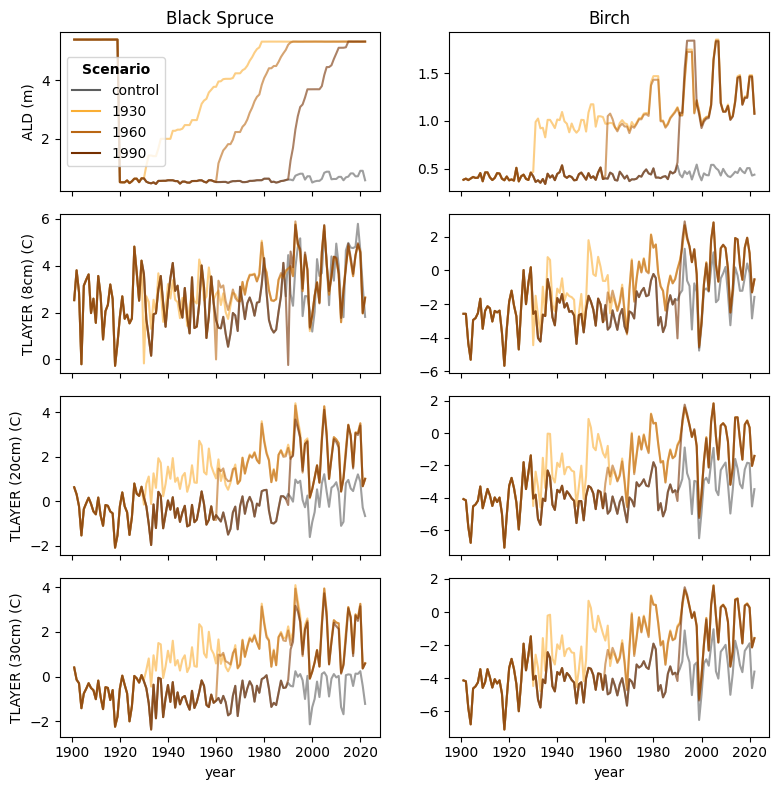

In [23]:
fig, axes = plt.subplots(4,2, figsize=(8,8), sharex=True)


sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], 
             x='year', y='ALD', hue='exp', ax=axes[0][0], palette=pal, alpha=0.6)
sns.lineplot(data=t_layers.loc[(t_layers['cmt']=='black_spruce') & (t_layers['z']==0.08)], 
             x='year', y='TLAYER', hue='exp', ax=axes[1][0], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=t_layers.loc[(t_layers['cmt']=='black_spruce') & (t_layers['z']==0.2)], 
             x='year', y='TLAYER', hue='exp', ax=axes[2][0], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=t_layers.loc[(t_layers['cmt']=='black_spruce') & (t_layers['z']==0.3)], 
             x='year', y='TLAYER', hue='exp', ax=axes[3][0], legend=False, palette=pal, alpha=0.6)

axes[0][0].set_title('Black Spruce')
axes[0][0].set_ylabel('ALD (m)')

new_labels = ['control', '1930', '1960', '1990']
legend=axes[0,0].legend(title='Scenario', frameon=True, title_fontproperties={'weight':'bold'}, fontsize=10)
for text, new_label in zip(legend.get_texts(), new_labels):
    text.set_text(new_label)
    
axes[1][0].set_ylabel('TLAYER (8cm) (C)')
axes[2][0].set_ylabel('TLAYER (20cm) (C)')
axes[3][0].set_ylabel('TLAYER (30cm) (C)')

sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], 
             x='year', y='ALD', hue='exp', ax=axes[0][1], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=t_layers.loc[(t_layers['cmt']=='birch') & (t_layers['z']==0.08)], 
             x='year', y='TLAYER', hue='exp', ax=axes[1][1], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=t_layers.loc[(t_layers['cmt']=='birch') & (t_layers['z']==0.2)], 
             x='year', y='TLAYER', hue='exp', ax=axes[2][1], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=t_layers.loc[(t_layers['cmt']=='birch') & (t_layers['z']==0.3)], 
             x='year', y='TLAYER', hue='exp', ax=axes[3][1], legend=False, palette=pal, alpha=0.6)

axes[0][1].set_ylabel('')
axes[1][1].set_ylabel('')
axes[2][1].set_ylabel('')
axes[3][1].set_ylabel('')

axes[0][1].set_title('Birch')


fig.tight_layout()
plt.savefig('ALD_tlayer_fire_exps.jpg', dpi=300)

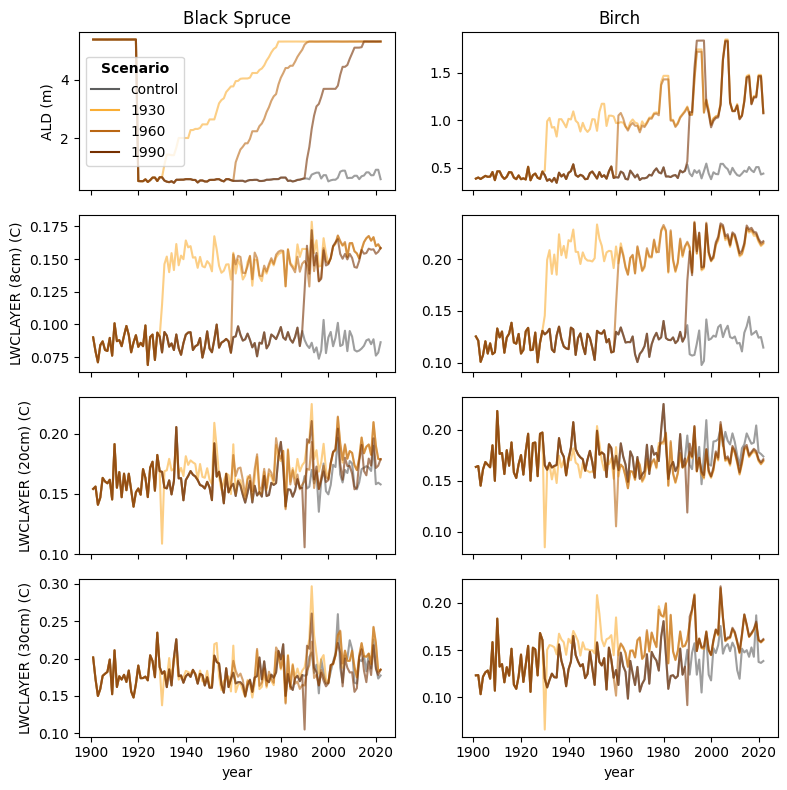

In [24]:
fig, axes = plt.subplots(4,2, figsize=(8,8), sharex=True)


sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], 
             x='year', y='ALD', hue='exp', ax=axes[0][0], palette=pal, alpha=0.6)
sns.lineplot(data=lwc_layers.loc[(lwc_layers['cmt']=='black_spruce') & (lwc_layers['z']==0.08)], 
             x='year', y='LWCLAYER', hue='exp', ax=axes[1][0], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=lwc_layers.loc[(lwc_layers['cmt']=='black_spruce') & (lwc_layers['z']==0.2)], 
             x='year', y='LWCLAYER', hue='exp', ax=axes[2][0], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=lwc_layers.loc[(lwc_layers['cmt']=='black_spruce') & (lwc_layers['z']==0.3)], 
             x='year', y='LWCLAYER', hue='exp', ax=axes[3][0], legend=False, palette=pal, alpha=0.6)

axes[0][0].set_title('Black Spruce')
axes[0][0].set_ylabel('ALD (m)')

new_labels = ['control', '1930', '1960', '1990']
legend=axes[0,0].legend(title='Scenario', frameon=True, title_fontproperties={'weight':'bold'}, fontsize=10)
for text, new_label in zip(legend.get_texts(), new_labels):
    text.set_text(new_label)
    
axes[1][0].set_ylabel('LWCLAYER (8cm) (C)')
axes[2][0].set_ylabel('LWCLAYER (20cm) (C)')
axes[3][0].set_ylabel('LWCLAYER (30cm) (C)')

sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], 
             x='year', y='ALD', hue='exp', ax=axes[0][1], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=lwc_layers.loc[(lwc_layers['cmt']=='birch') & (lwc_layers['z']==0.08)], 
             x='year', y='LWCLAYER', hue='exp', ax=axes[1][1], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=lwc_layers.loc[(lwc_layers['cmt']=='birch') & (lwc_layers['z']==0.2)], 
             x='year', y='LWCLAYER', hue='exp', ax=axes[2][1], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=lwc_layers.loc[(lwc_layers['cmt']=='birch') & (lwc_layers['z']==0.3)], 
             x='year', y='LWCLAYER', hue='exp', ax=axes[3][1], legend=False, palette=pal, alpha=0.6)

axes[0][1].set_ylabel('')
axes[1][1].set_ylabel('')
axes[2][1].set_ylabel('')
axes[3][1].set_ylabel('')

axes[0][1].set_title('Birch')


fig.tight_layout()
plt.savefig('ALD_lwclayer_fire_exps.jpg', dpi=300)

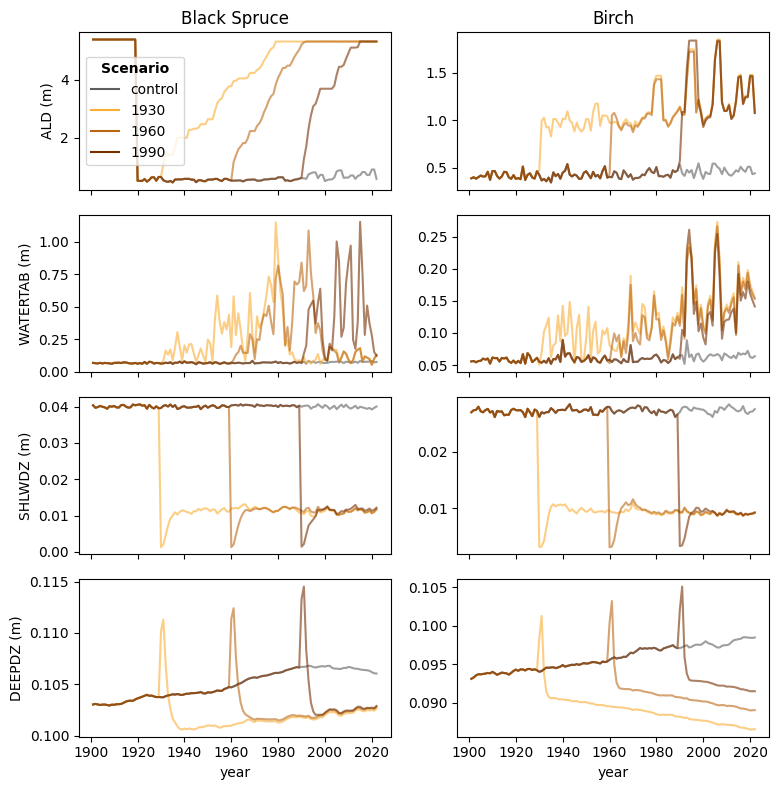

In [25]:
fig, axes = plt.subplots(4,2, figsize=(8,8), sharex=True)


sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], 
             x='year', y='ALD', hue='exp', ax=axes[0][0], palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], 
             x='year', y='WATERTAB', hue='exp', ax=axes[1][0], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], 
             x='year', y='SHLWDZ', hue='exp', ax=axes[2][0], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], 
             x='year', y='DEEPDZ', hue='exp', ax=axes[3][0], legend=False, palette=pal, alpha=0.6)

axes[0][0].set_title('Black Spruce')
axes[0][0].set_ylabel('ALD (m)')

new_labels = ['control', '1930', '1960', '1990']
legend=axes[0,0].legend(title='Scenario', frameon=True, title_fontproperties={'weight':'bold'}, fontsize=10)
for text, new_label in zip(legend.get_texts(), new_labels):
    text.set_text(new_label)
    
axes[1][0].set_ylabel('WATERTAB (m)')
axes[2][0].set_ylabel('SHLWDZ (m)')
axes[3][0].set_ylabel('DEEPDZ (m)')

sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], 
             x='year', y='ALD', hue='exp', ax=axes[0][1], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], 
             x='year', y='WATERTAB', hue='exp', ax=axes[1][1], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], 
             x='year', y='SHLWDZ', hue='exp', ax=axes[2][1], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], 
             x='year', y='DEEPDZ', hue='exp', ax=axes[3][1], legend=False, palette=pal, alpha=0.6)

axes[0][1].set_ylabel('')
axes[1][1].set_ylabel('')
axes[2][1].set_ylabel('')
axes[3][1].set_ylabel('')

axes[0][1].set_title('Birch')


fig.tight_layout()
plt.savefig('WATERTAB_DZ_fire_exps.jpg', dpi=300)

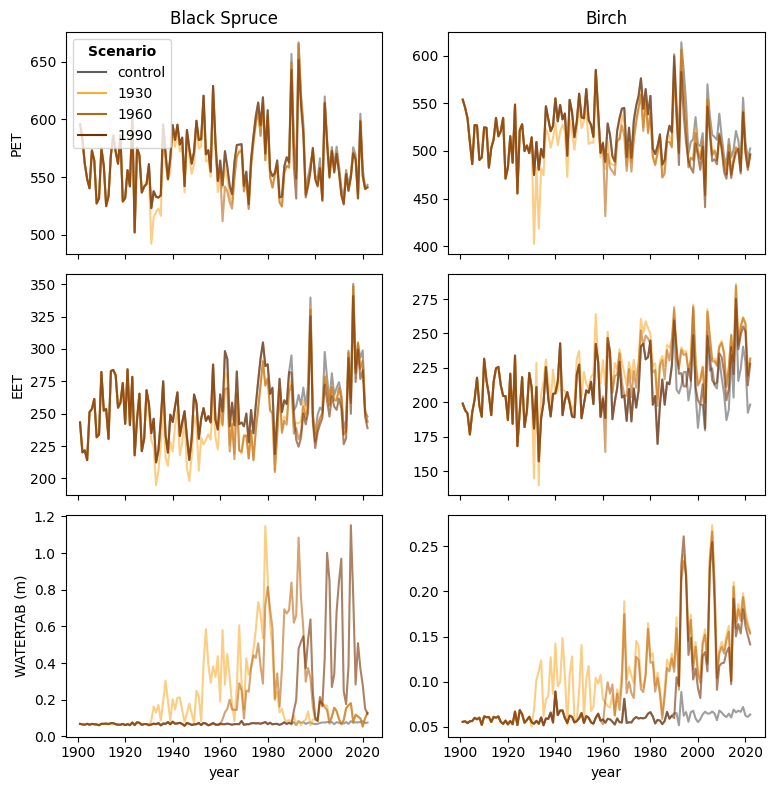

In [26]:
fig, axes = plt.subplots(3,2, figsize=(8,8), sharex=True)


sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], 
             x='year', y='PET', hue='exp', ax=axes[0][0], palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], 
             x='year', y='EET', hue='exp', ax=axes[1][0], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], 
             x='year', y='WATERTAB', hue='exp', ax=axes[2][0], legend=False, palette=pal, alpha=0.6)

axes[0][0].set_title('Black Spruce')
axes[0][0].set_ylabel('PET')

new_labels = ['control', '1930', '1960', '1990']
legend=axes[0,0].legend(title='Scenario', frameon=True, title_fontproperties={'weight':'bold'}, fontsize=10)
for text, new_label in zip(legend.get_texts(), new_labels):
    text.set_text(new_label)
    
axes[1][0].set_ylabel('EET')
axes[2][0].set_ylabel('WATERTAB (m)')


sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], 
             x='year', y='PET', hue='exp', ax=axes[0][1], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], 
             x='year', y='EET', hue='exp', ax=axes[1][1], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], 
             x='year', y='WATERTAB', hue='exp', ax=axes[2][1], legend=False, palette=pal, alpha=0.6)


axes[0][1].set_ylabel('')
axes[1][1].set_ylabel('')
axes[2][1].set_ylabel('')

axes[0][1].set_title('Birch')


fig.tight_layout()
plt.savefig('ET_fire_exps.jpg', dpi=300)

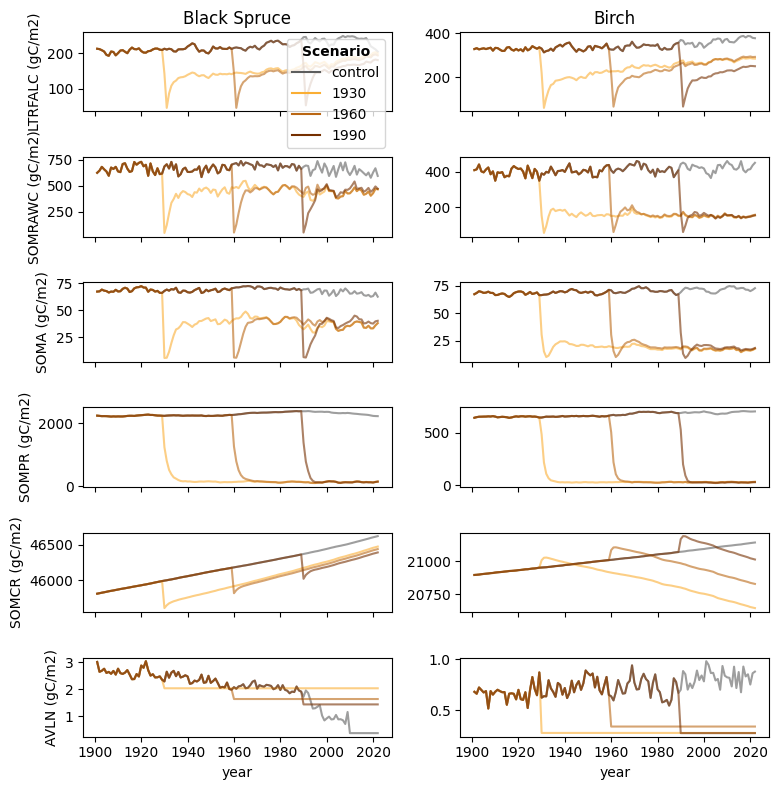

In [27]:
fig, axes = plt.subplots(6,2, figsize=(8,8), sharex=True)


sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], 
             x='year', y='LTRFALC', hue='exp', ax=axes[0][0], palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], 
             x='year', y='SOMRAWC', hue='exp', ax=axes[1][0], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], 
             x='year', y='SOMA', hue='exp', ax=axes[2][0], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], 
             x='year', y='SOMPR', hue='exp', ax=axes[3][0], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], 
             x='year', y='SOMCR', hue='exp', ax=axes[4][0], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], 
             x='year', y='AVLN', hue='exp', ax=axes[5][0], legend=False, palette=pal, alpha=0.6)

axes[0][0].set_title('Black Spruce')
axes[0][0].set_ylabel('LTRFALC (gC/m2)')

new_labels = ['control', '1930', '1960', '1990']
legend=axes[0,0].legend(title='Scenario', frameon=True, title_fontproperties={'weight':'bold'}, fontsize=10)
for text, new_label in zip(legend.get_texts(), new_labels):
    text.set_text(new_label)
    
axes[1][0].set_ylabel('SOMRAWC (gC/m2)')
axes[2][0].set_ylabel('SOMA (gC/m2)')
axes[3][0].set_ylabel('SOMPR (gC/m2)')
axes[4][0].set_ylabel('SOMCR (gC/m2)')
axes[5][0].set_ylabel('AVLN (gC/m2)')

#axes[5][0].set_ylim(1,2)

sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], 
             x='year', y='LTRFALC', hue='exp', ax=axes[0][1], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], 
             x='year', y='SOMRAWC', hue='exp', ax=axes[1][1], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], 
             x='year', y='SOMA', hue='exp', ax=axes[2][1], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], 
             x='year', y='SOMPR', hue='exp', ax=axes[3][1], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], 
             x='year', y='SOMCR', hue='exp', ax=axes[4][1], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], 
             x='year', y='AVLN', hue='exp', ax=axes[5][1], legend=False, palette=pal, alpha=0.6)

axes[0][1].set_ylabel('')
axes[1][1].set_ylabel('')
axes[2][1].set_ylabel('')
axes[3][1].set_ylabel('')
axes[4][1].set_ylabel('')
axes[5][1].set_ylabel('')

axes[0][1].set_title('Birch')


fig.tight_layout()
plt.savefig('Pools_fire_exps.jpg', dpi=300)

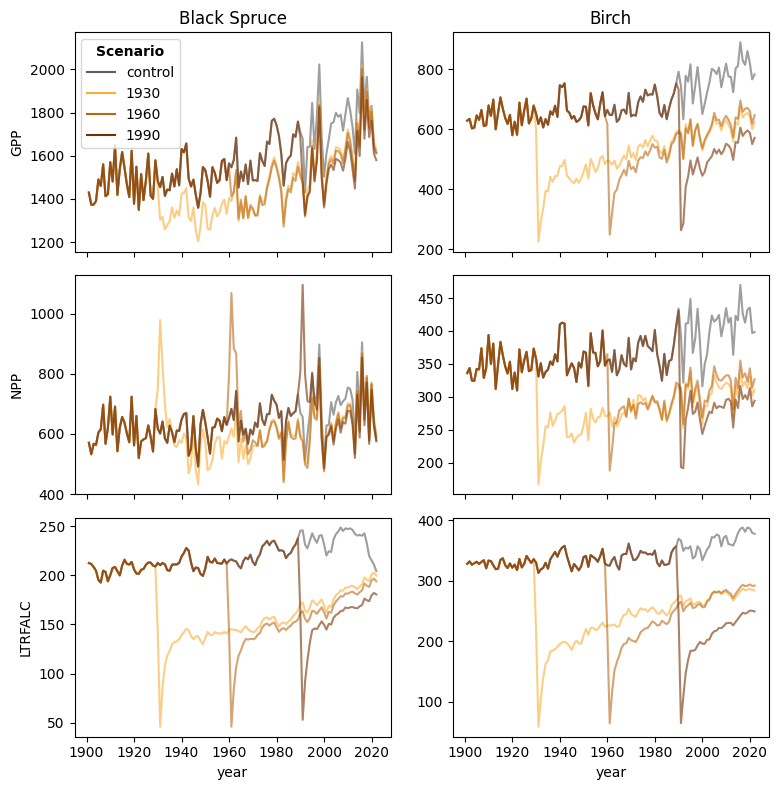

In [28]:
fig, axes = plt.subplots(3,2, figsize=(8,8), sharex=True)


sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], 
             x='year', y='GPP', hue='exp', ax=axes[0][0], palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], 
             x='year', y='NPP', hue='exp', ax=axes[1][0], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='black_spruce'], 
             x='year', y='LTRFALC', hue='exp', ax=axes[2][0], legend=False, palette=pal, alpha=0.6)

axes[0][0].set_title('Black Spruce')
axes[0][0].set_ylabel('GPP')

new_labels = ['control', '1930', '1960', '1990']
legend=axes[0,0].legend(title='Scenario', frameon=True, title_fontproperties={'weight':'bold'}, fontsize=10)
for text, new_label in zip(legend.get_texts(), new_labels):
    text.set_text(new_label)
    
axes[1][0].set_ylabel('NPP')
axes[2][0].set_ylabel('LTRFALC')


sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], 
             x='year', y='GPP', hue='exp', ax=axes[0][1], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], 
             x='year', y='NPP', hue='exp', ax=axes[1][1], legend=False, palette=pal, alpha=0.6)
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], 
             x='year', y='LTRFALC', hue='exp', ax=axes[2][1], legend=False, palette=pal, alpha=0.6)


axes[0][1].set_ylabel('')
axes[1][1].set_ylabel('')
axes[2][1].set_ylabel('')

axes[0][1].set_title('Birch')


fig.tight_layout()
plt.savefig('ET_fire_exps.jpg', dpi=300)

In [29]:
vegc_yearly = results_yearly_pft.groupby(by=['burn_year', 'cmt', 'exp', 'year']).sum().reset_index()
vegc_yearly['VEGC_diff'] = vegc_yearly['VEGC'].diff()
vegc_yearly = vegc_yearly.merge(results_yearly[['burn_year', 'cmt', 'exp', 'year', 'NPP', 'LTRFALC']], on = ['burn_year', 'cmt', 'exp', 'year'])
vegc_yearly['balance'] = vegc_yearly['VEGC_diff'] - (vegc_yearly['NPP'] - vegc_yearly['LTRFALC'])
vegc_yearly

,burn_year,cmt,exp,year,pftpart,VEGC,VEGC_diff,NPP,LTRFALC,balance
0,1900,birch,control,1901,15,3140.785718,NaN,335.924296,328.339418,NaN
1,1900,birch,control,1902,15,3130.849789,-9.935930,343.608518,332.259713,-21.284735
2,1900,birch,control,1903,15,3116.450624,-14.399165,324.548975,326.825820,-12.122320
3,1900,birch,control,1904,15,3098.300357,-18.150267,324.215953,329.365101,-13.001119
4,1900,birch,control,1905,15,3086.478315,-11.822042,342.305274,331.690276,-22.437040
...,...,...,...,...,...,...,...,...,...,...
971,1990,black_spruce,burn_1990,2018,15,3810.040232,55.362915,771.518729,174.628537,-541.527278
972,1990,black_spruce,burn_1990,2019,15,3786.273261,-23.766970,566.601213,173.568843,-416.799341
973,1990,black_spruce,burn_1990,2020,15,3804.000536,17.727274,746.618535,179.508245,-549.383016
974,1990,black_spruce,burn_1990,2021,15,3818.363534,14.362998,629.088892,181.998543,-432.727351


<AxesSubplot:xlabel='year', ylabel='balance'>

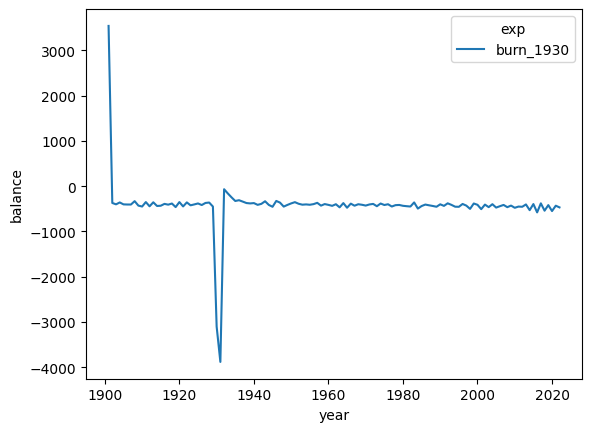

In [30]:
sns.lineplot(data = vegc_yearly.loc[(vegc_yearly['cmt']=='black_spruce') & (vegc_yearly['exp']=='burn_1930')], x='year', y = 'balance', hue = 'exp')

In [31]:
#DWDC_cont = get_yearly_data(data_paths[0], 'DWDC')
DWDC_1930 = get_yearly_data(data_paths[1], 'DWDC')
#DEADC_cont = get_yearly_data(data_paths[0], 'DEADC')
DEADC_1930 = get_yearly_data(data_paths[1], 'DEADC')
DWDRH_1930 = get_yearly_data(data_paths[1], 'DWDRH')

Trying to open:  /data/workflows/BONA-black-spruce-fire-1930/output/DWDC_yearly_tr.nc


FileNotFoundError: [Errno 2] No such file or directory: b'/data/workflows/BONA-black-spruce-fire-1930/output/DWDC_yearly_tr.nc'

In [ ]:
fig, axes = plt.subplots(3,1, sharex=True)

sns.lineplot(data=DWDC_1930, x='time', y='DWDC', ax=axes[0])
sns.lineplot(data=DEADC_1930, x='time', y='DEADC', ax=axes[1])
sns.lineplot(data=DWDRH_1930, x='time', y='DWDRH', ax=axes[2])

In [ ]:
sns.lineplot(data=results_yearly.loc[results_yearly['cmt']=='birch'], 
             x='year', y=results_yearly.loc[results_yearly['cmt']=='birch','EET']/results_yearly.loc[results_yearly['cmt']=='birch','PET'], 
             hue='exp', palette=pal, alpha=0.6)